<p style="font-size: 18px;">
  This is the accompanying code for the post titled "Recommender Systems with PyTorch. From Data to Decisions: A Journey Through AI-Powered Recommendations"<br>
  You can find it <a href="https://pureai.substack.com/p/recommender-systems-with-pytorch">here</a>.<br>
  Published: December 23, 2023<br>
  <a href="https://pureai.substack.com">https://pureai.substack.com</a>
</p>

Welcome to this Jupyter notebook! If you're new to Python or don't have it installed on your system, don't worry; you can still follow along and explore the code.

Here's a quick guide to getting started:

- Using an Online Platform: You can run this notebook in a web browser using platforms like Google Colab or Binder. These services offer free access to Jupyter notebooks and don't require any installation.
- Installing Python Locally: If you'd prefer to run this notebook on your own machine, you'll need to install Python. A popular distribution for scientific computing is Anaconda, which includes Python, Jupyter, and other useful tools.
  - Download Anaconda from [here](https://www.anaconda.com/download).
  - Follow the installation instructions for your operating system.
  - Launch Jupyter Notebook from Anaconda Navigator or by typing jupyter notebook in your command line or terminal.
- Opening the Notebook: Once you have Jupyter running, navigate to the location of this notebook file (.ipynb) and click on it to open.
- Running the Code: You can run each cell in the notebook by selecting it and pressing Shift + Enter. Feel free to modify the code and experiment with it.
- Need More Help?: If you're new to Python or Jupyter notebooks, you might find these resources helpful:
  - [Python.org's Beginner's Guide](https://docs.python.org/3/tutorial/index.html)
  - [Jupyter Notebook Basics](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html)

*Note: this Notebook/Code feature the use of Poetry, a dependency and virtual environment manager. If you don't have Poetry, please install it via the Python package manager pip. Then change directories to this code, and run `poetry install --no-root`, which will install all of th required dependencies for you. You then select the poetry virtual environment as your Python kernel.

Happy coding, and enjoy exploring the fascinating world of Recommender Systems with PyTorch!

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys

Let's set the device depending upon if you have a GPU or not.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

You'll need to download the MovieLens 'small' dataset from <a href="https://grouplens.org/datasets/movielens/latest/">here</a>. Place the dataset folder titled 'ml-latest-small' in the same directory as the code.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys

root_path = "/content/drive/MyDrive/Colab Notebooks/RecommenderSystem-PyTorch"
data_path = root_path + "/ml-latest-small"

sys.path.append(root_path)

In [15]:
df = pd.read_csv(root_path + "/ml-latest-small/ratings.csv")

df.head(50)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


Let's do a little bit of an exploration of our dataset to better understand it.

In [7]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [8]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
df.userId.nunique(), df.movieId.nunique()

(610, 9724)

We have 610 unique uderIds and 9724 unique movieIds.

In [10]:
df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

Let's plot a quick histogram of the number of ratings versus their counts.

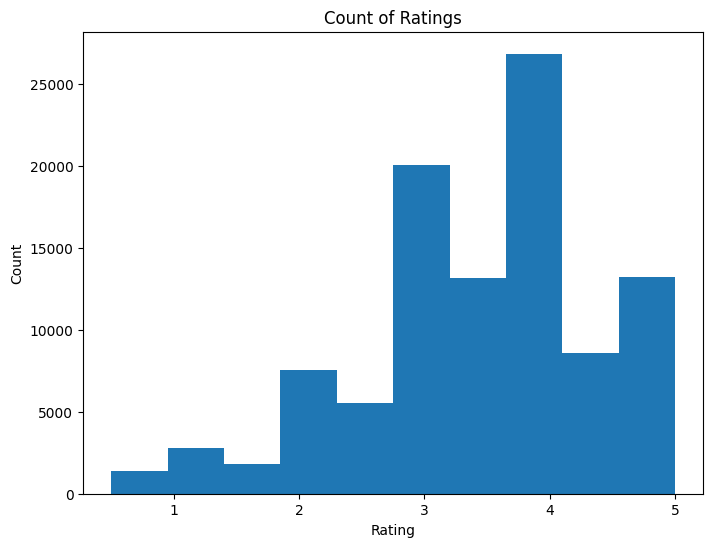

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(df.rating)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Ratings")
plt.show()

Let's now define the MovieLensDataset class.

In [12]:
class MovieLensDataset(Dataset):
    """
    The Movie Lens Dataset class. This class prepares the dataset for training and validation.
    """

    def __init__(self, users, movies, ratings):
        """
        Initializes the dataset object with user, movie, and rating data.
        """
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.users)

    def __getitem__(self, item):
        """
        Retrieves a sample from the dataset at the specified index.
        """
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.float),
        }

And now let's define the RecommendationSystemModel neural network in PyTorch.

In [13]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        embedding_size=256,
        hidden_dim=256,
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers
        # C: use the existing pytorch nn.Embedding layer
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # Hidden layers
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)

        # C: the output is the rating from one user to one movie
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, users, movies):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

We move to define our train and validation datasets.

In [16]:
le_user = preprocessing.LabelEncoder()
le_movie = preprocessing.LabelEncoder()
# C: further use LabelEncoder to convert df.userID and df.movieID into labels
df.userId = le_user.fit_transform(df.userId.values)
df.movieId = le_movie.fit_transform(df.movieId.values)

display(df.head(10))

df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=3, stratify=df.rating.values
)

train_dataset = MovieLensDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values,
)

valid_dataset = MovieLensDataset(
    users=df_val.userId.values,
    movies=df_val.movieId.values,
    ratings=df_val.rating.values,
)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,43,5.0,964983815
4,0,46,5.0,964982931
5,0,62,3.0,964982400
6,0,89,5.0,964980868
7,0,97,4.0,964982176
8,0,124,5.0,964984041
9,0,130,5.0,964984100


We now move to create the dataloaders that will be used during training and inference.

In [17]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)
val_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We create the recommendation model as well as define the optimizer and loss function.

In [19]:
recommendation_model = RecommendationSystemModel(
    num_users=len(le_user.classes_),
    num_movies=len(le_movie.classes_),
    embedding_size=64,
    hidden_dim=128,
    dropout_rate=0.1,
) # .to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

We define a function to log the training progress.

In [20]:
EPOCHS = 2


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)

The following is our training loop that will train our network over 2 epochs.

In [23]:
total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(
            train_data["users"], train_data["movies"]
        )
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = (
            train_data["ratings"].to(torch.float32)
        )  # Assuming ratings is already 1D

        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if (
            step_count % log_progress_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
            )
            total_loss = 0

Training on 90752 samples...


02/02 | Step: 90752/90752 | Avg Loss: 0.095250496

After training, plot the average losses. We should expect to see a decrease in the loss as training ocurrs.

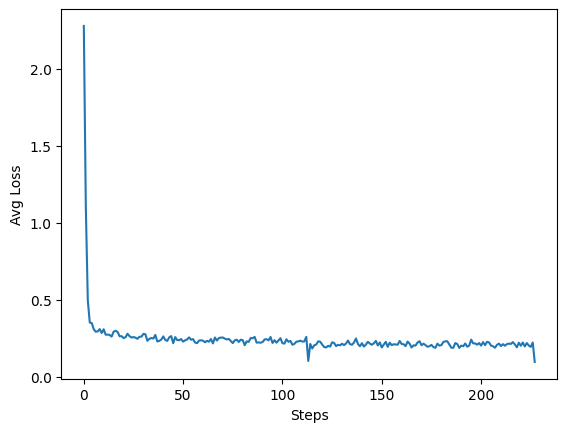

In [24]:
plt.figure()
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Avg Loss")
plt.show()

We will compute the Root Mean Squared Error between our predicted values versus the true values of the ratings.

In [27]:
from sklearn.metrics import mean_squared_error

y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recommendation_model(
            valid_data["users"], valid_data["movies"]
        )
        ratings = valid_data["ratings"]
        y_pred.extend(output.cpu().numpy())
        y_true.extend(ratings.cpu().numpy())

# Calculate RMSE
rms = mean_squared_error(y_true, y_pred, squared=False)
print(f"RMSE: {rms:.4f}")

RMSE: 0.9169


For other metrics, we can look at the precision@k and recall@k. In the context of recommender systems, precision@k measures the proportion of recommended items in the top-k set that are relevant, while recall@k measures the proportion of relevant items found in the top-k recommendations.

In [29]:
from collections import defaultdict


def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum(
        (true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k]
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall


user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"]
        movies = valid_data["movies"]
        ratings = valid_data["ratings"]
        output = recommendation_model(users, movies)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall

In [30]:
average_precision = sum(prec for prec in user_precisions.values()) / len(
    user_precisions
)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(
    user_based_recalls
)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 0.8906
recall @ 50: 0.8953


Let's now predict a user's top movies they haven't seen based on movies they rated highly:

In [34]:
def recommend_top_movies(model, user_id, all_movies, seen_movies, k=5, batch_size=100):
    model.eval()
    unseen_movies = [m for m in all_movies if m not in seen_movies]
    predictions = []

    with torch.no_grad():
        for i in range(0, len(unseen_movies), batch_size):
            batch_unseen_movies = unseen_movies[i:i+batch_size]
            user_tensor = torch.tensor([user_id] * len(batch_unseen_movies))
            movie_tensor = torch.tensor(batch_unseen_movies)
            predicted_ratings = model(user_tensor, movie_tensor).view(-1).tolist()
            predictions.extend(zip(batch_unseen_movies, predicted_ratings))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    return top_k_movies

def get_movies_with_genres(movie_ids, df_movies):
    # Select the relevant movies and create a new DataFrame
    movies_with_genres = df_movies[df_movies['movieId'].isin(movie_ids)].copy()
    # Concatenate movie titles with their genres
    movies_with_genres['title_with_genres'] = movies_with_genres[['title', 'genres']].agg(' - '.join, axis=1)
    return movies_with_genres['title_with_genres'].tolist()

# Load movie titles and genres
df_movies = pd.read_csv(root_path + "/ml-latest-small/movies.csv")

# Prepare all_movies and seen_movies
all_movies = df['movieId'].unique().tolist()
user_id = 1 # A random userId
seen_movies = set(df[df['userId'] == user_id]['movieId'].tolist())

# Get recommendations
recommendations = recommend_top_movies(
    recommendation_model, user_id, all_movies, seen_movies
)

# Get movie titles with genres for recommended and seen movies
recommended_movies_with_genres = get_movies_with_genres(recommendations, df_movies)

# For the user's top 10 rated seen movies, get movies with genres
user_top_ten_seen_movies = df[df['userId'] == user_id].sort_values(by="rating", ascending=False).head(10)
seen_movies_with_genres = get_movies_with_genres(user_top_ten_seen_movies['movieId'], df_movies)

print(f"Recommended movies:\n\n{recommended_movies_with_genres}\n\nbased on these movies the user has watched:\n\n{seen_movies_with_genres}")

Recommended movies:

['In the Line of Fire (1993) - Action|Thriller', '24 Hour Party People (2002) - Comedy|Drama|Musical']

based on these movies the user has watched:

['High Noon (1952) - Drama|Western', 'Hannah and Her Sisters (1986) - Comedy|Drama|Romance', 'After Hours (1985) - Comedy|Thriller', 'AVP: Alien vs. Predator (2004) - Action|Horror|Sci-Fi|Thriller']


In [36]:
len(recommendations)

5

In [ ]:
'''

The above method is close to the deep-crossing recommendation method. Embedding the features and then stacking them, after several layers of MLP, get the
output of rating.
refer to the book "深度学习推荐系统" 3.3.2 Deep Crossing模型的网络结构
'''